In [2]:
from numba import cuda, jit, int64
import numpy as np
import timeit, random, time
import matplotlib.pyplot as plt
from PIL import Image, ImageOps

# Preperations
#### For the first few steps, we will use an image of a dog. The file is named "dog.jpeg." For simplicity, we will convert this image to a 56x56 grayscale image.

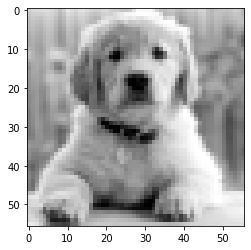

In [3]:
img = Image.open("dog.jpeg")
img = img.resize(size=(56, 56))
img = ImageOps.grayscale(img)
img = np.array(img)
plt.imshow(img, cmap="gray")

#### When using a convolution layer, there are several different kernels that can be applied to the image. Here are some popular 3x3 kernels (sharpen, blur, and outline).

In [4]:
sharpen_matrix = np.array([
    [0, -1, 0],
    [-1, 5, -1],
    [0, -1, 0]
])

blur_matrix = np.array([
    [0.0625, 0.125, 0.0625],
    [0.125, 0.25, 0.125],
    [0.0625, 0.125, 0.0625]
])

outline_matrix = np.array([
    [-1, -1, -1],
    [-1, 8, -1],
    [-1, -1, -1]
])

#### Below is a function that takes in the size of the image and size of the kernel and then calculates the size of the convolved output.

In [5]:
def calculate_target_size(img_size, kernel_size):
    width = img_size[0] - kernel_size[0] + 1
    height = img_size[1] - kernel_size[1] + 1
    return (width, height)

#### Below is a convolution function written in basic Python. It loops through every possible kernel location in the image (by looping through each output location in the convolved_img) and then calculates the value based on the image values and the kernel.

In [14]:
def normal_convolve(img, kernel): # Both inputs are np.arrays
    # Calculate the final size of the convolved image
    tgt_size = calculate_target_size(
        img_size=img.shape,
        kernel_size=kernel.shape
    )
    
    # 2D array of zeros
    convolved_img = np.zeros(shape=tgt_size)
    
    # Iterate over the rows
    for i in range(tgt_size[0]):
        # Iterate over the columns
        for j in range(tgt_size[1]):
            # Set initial sum to 0
            s = 0
            
            # Generate a new array for the section of the original image that we will iterate over. This probably takes a bit more time, but it is easier to understand
            kx = kernel.shape[0]
            ky = kernel.shape[1]
            mat = img[i:i+kx, j:j+ky]

            # Loop through each value in the image and the kernel and find the sum
            for k in range(mat.shape[0]):
                for l in range(mat.shape[1]):
                    s += mat[k, l] * kernel[k, l]
                  
            # Set the sum to the corresponding output pixel. Max(0, s) is a ReLU function that keeps all values positive.
            convolved_img[i, j] = max(0, s)
            
    return convolved_img

#### Let's try it on the dog image! You can see how each kernel results in a completely different output.

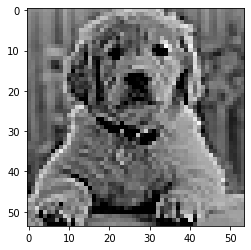

In [15]:
img_sharp = normal_convolve(img=np.array(img), kernel=sharpen_matrix)
plt.imshow(img_sharp, cmap="gray")

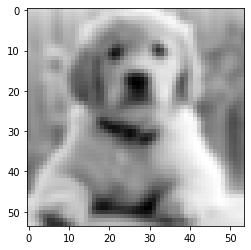

In [16]:
img_blur = normal_convolve(img=np.array(img), kernel=blur_matrix)
plt.imshow(img_blur, cmap="gray")

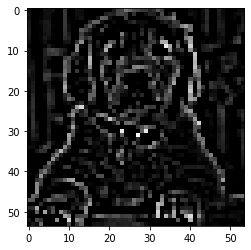

In [17]:
img_outline = normal_convolve(img=np.array(img), kernel=outline_matrix)
plt.imshow(img_outline, cmap="gray")

#### Now let's time how long this convolution takes! It should take around 400-500 ms. This value will change based on how large the image is (in this case it is 56x56)
This time can be sped up a decent bit, especially with the matrix multiplication part. Using np.multiply will result in faster times, but it is easier to understand the plain Python code. There are also other optimizations that can be made, but the main point is that this function is pretty slow and will become ETREMELY slow on larger images.

In [13]:
%timeit normal_convolve(img=np.array(img), kernel=sharpen_matrix)

476 ms ± 7.83 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### Now let's utilize the GPU! We can pretty much reuse the code from earlier, but instead of using the overall i and j loop, we can use threads and give each thread a different i and j.

In [19]:
def gpu_convolve_runner(img, kernel):
    # Generate the output array like before
    tgt_size = calculate_target_size(
        img_size=img.shape,
        kernel_size=kernel.shape
    )
    convolved_img = np.zeros(shape=tgt_size)
    
    # The maximum number of threads per block is 1024, so the maximum would be 32 by 32. We use 16 by 16 here because why not :D
    blockDim = (16, 16)
    
    # This will determine the number of blocks needed and the dimension of the grid
    gridDim = (tgt_size[0] // blockDim[0] + 1, tgt_size[1] // blockDim[1] + 1)
    
    # Calling the GPU function. This will run the gpu_convolve function on every single thread in every block, and each thread will perform one singular convolution.
    gpu_convolve[gridDim, blockDim](np.array(img), kernel, convolved_img)
    
    return convolved_img
    

@cuda.jit
def gpu_convolve(image, mask, result):
    # cuda.gird(2) will return the absolute position of the thread in the entire grid. The 2 is the number of dimensions. Essentially, this is 
    # cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x but in a single function.
    i, j = cuda.grid(2)
    
    # If i or j are outside of the bounds, return. This is because the largest i and j will always be a multiple of 16 (the block dimensions)
    image_rows, image_cols = result.shape
    if (i >= image_rows) or (j >= image_cols): 
        return
    
    # Set initial sum to 0
    s = 0
    
    # Create the sub-array
    kx = mask.shape[0]
    ky = mask.shape[1]
    mat = image[i:i+kx, j:j+ky]
    
    # Calculate the sum
    for k in range(mat.shape[0]):
        for l in range(mat.shape[1]):
            s += mat[k, l] * mask[k, l]

    result[i, j] = max(0, s) # relu


#### Testing the function

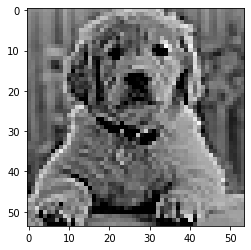

In [20]:
img_sharp2 = gpu_convolve_runner(img=np.array(img), kernel=sharpen_matrix)
plt.imshow(img_sharp2, cmap="gray")

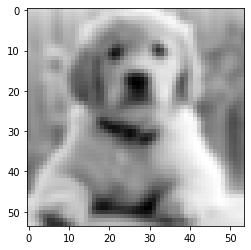

In [21]:
img_blur2 = gpu_convolve_runner(img=np.array(img), kernel=blur_matrix)
plt.imshow(img_blur2, cmap="gray")

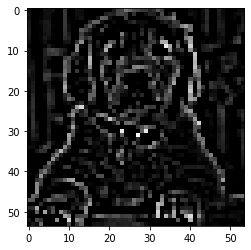

In [22]:
img_outline2 = gpu_convolve_runner(img=np.array(img), kernel=outline_matrix)
plt.imshow(img_outline2, cmap="gray")

#### Confirm that they give the same output

In [24]:
(np.array_equal(img_sharp, img_sharp2), np.array_equal(img_blur, img_blur2), np.array_equal(img_outline, img_outline2))

(True, True, True)

#### Timing the GPU convolution function. It should take around 5-10 ms
Wow! This is so much faster than the normal convolution!!

In [25]:
%timeit img_sharp2 = gpu_convolve_runner(img=np.array(img), kernel=sharpen_matrix)

7.55 ms ± 227 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


#### Below is a max pooling function written in basic Python. It loops through every pooled dimension (given by dim) in the image by looping through each output location, and then it finds the maximum value within each "pool".

In [20]:
from math import ceil
def normal_maxpool(img, dim):
    # Determine size of the maxpool
    size_x = ceil(img.shape[0] / dim[0])
    size_y = ceil(img.shape[1] / dim[1])
    result = np.zeros(shape=(size_x, size_y))
    
    # Loop through each output
    for i in range(size_x):
        for j in range(size_y):
            maxpool = -999
            # Loop through each pixel in the "pool"
            for k in range(dim[0]):
                for l in range(dim[1]):
                    #Make sure that the dimensions are within the picture
                    if dim[0]*i+k < img.shape[0] and dim[1]*j+l < img.shape[1]:
                        # set maxpool to the maximum value
                        maxpool = max(img[dim[0]*i+k][dim[1]*j+l], maxpool)
                    else:
                        # If the dimensions are outside the picture, just set that value to 0. This is known as zero-padding.
                        maxpool = max(0, maxpool)
            # Set the output the the maximum value
            result[i][j] = maxpool
    return result

#### Testing the maxpool on the convolved images of the dog. There isn't that much to see, as it is kind of just lowering the resolution of the image.

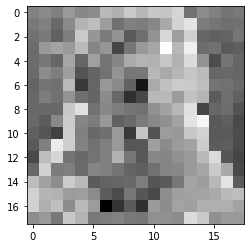

In [37]:
img_sharp_pooled = normal_maxpool(img_sharp, (3,3))
plt.imshow(img_sharp_pooled, cmap="gray")

#### Testing the speed of the maxpool. It is significantly faster than the convolution because the output dimension is much smaller and it only goes over each pixel in the original image once.

In [25]:
%timeit img_sharp_pooled = normal_maxpool(img_sharp, (3,3))

18.1 ms ± 81.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


#### Below is the code for a max pooling algorithm on the GPU. Just like the convolution, we can just convert the i and j for loops into i,j = cuda.grid(2), while keeping the rest of the code approximately the same.

In [42]:
from math import ceil
def gpu_maxpool_runner(img, dim):
    size_x = ceil(img.shape[0] / dim[0])
    size_y = ceil(img.shape[1] / dim[1])
    
    result = np.zeros(shape=(size_x, size_y))
    
    blockDim = (16, 16)
    gridDim = (size_x // blockDim[0] + 1, size_y // blockDim[1] + 1)
    
    gpu_maxpool[gridDim, blockDim](np.array(img), np.array(dim), result)
    
    return result

@cuda.jit
def gpu_maxpool(img, dim, res):
    i, j = cuda.grid(2)
        
    if (i >= res.shape[0]) or (j >= res.shape[1]): 
        return
        
    maxpool = -999
    
    for k in range(dim[0]):
        for l in range(dim[1]):
            if dim[0]*i+k < img.shape[0] and dim[1]*j+l < img.shape[1]:
                maxpool = max(img[dim[0]*i+k][dim[1]*j+l], maxpool)
            else:
                maxpool = max(0, maxpool)

    res[i][j] = maxpool

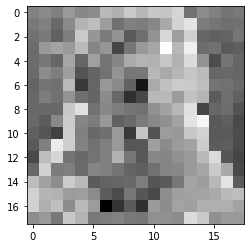

In [43]:
img_sharp_pooled2 = gpu_maxpool_runner(img_sharp, (3,3))
plt.imshow(img_sharp_pooled2, cmap="gray")

In [45]:
%timeit img_sharp_pooled2 = gpu_maxpool_runner(img_sharp, (3,3))

6.94 ms ± 61.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [44]:
np.array_equal(img_sharp_pooled, img_sharp_pooled2)

True

In [50]:
def convolve_maxpool_normal(img):
    img = normal_convolve(img, outline_matrix)
    img = normal_maxpool(img, (2, 2))
    img = normal_convolve(img, sharpen_matrix)
    img = normal_maxpool(img, (2, 2))
    return img

def convolve_maxpool_gpu(img):
    img = gpu_convolve_runner(img, outline_matrix)
    img = gpu_maxpool_runner(img, (2, 2))
    img = gpu_convolve_runner(img, sharpen_matrix)
    img = gpu_maxpool_runner(img, (2, 2))
    return img

In [ ]:
from tensorflow import keras
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

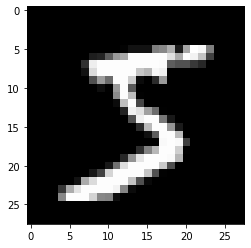

In [64]:
test_img = x_train[0]
# test_img = img.resize(size=(224, 224))
# test_img = ImageOps.grayscale(img)
plt.imshow(test_img, cmap="gray")

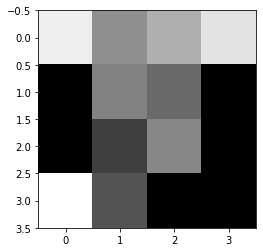

In [65]:
img_final = convolve_maxpool_normal(np.array(test_img))
plt.imshow(img_final, cmap="gray")

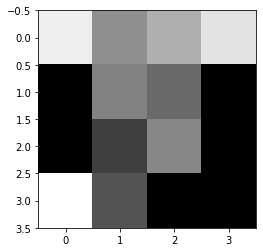

In [66]:
img_final2 = convolve_maxpool_gpu(np.array(test_img))
plt.imshow(img_final2, cmap="gray")

In [56]:
%timeit img_final = convolve_maxpool_normal(np.array(test_img))

169 ms ± 673 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [57]:
%timeit img_final2 = convolve_maxpool_gpu(np.array(test_img))

27.3 ms ± 455 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


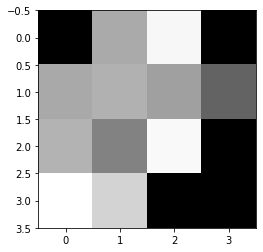

In [68]:
plt.imshow(convolve_maxpool_gpu(x_train[1]), cmap="gray")

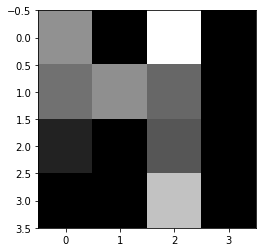

In [69]:
plt.imshow(convolve_maxpool_gpu(x_train[2]), cmap="gray")